In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('QVI_data.csv')

In [13]:
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MONTH_ID,price_per_u
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810,3.0
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809,2.7
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903,3.6
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903,3.0
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811,1.9


## Set metrics for the dataset


In [28]:
# Set Month ID
df['DATE'] = pd.to_datetime(df['DATE'])
df.loc[:, 'MONTH_ID'] = df['DATE'].dt.year.astype('str') + df['DATE'].dt.month.apply(lambda x: str(x).zfill(2))

# Set $ per Unit
df.loc[:, 'price_per_u'] = df['TOT_SALES'] / df['PROD_QTY']

In [29]:
trail_time = pd.to_datetime('20190201', format='%Y%m%d')
df_pre_trail = df[df['DATE'] < trail_time]
df_pre_trail

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MONTH_ID,price_per_u
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810,3.0
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809,2.7
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811,1.9
5,1005,2018-12-28,1,6,86,Cheetos Puffs 165g,1,2.8,165,CHEETOS,MIDAGE SINGLES/COUPLES,Mainstream,201812,2.8
6,1007,2018-12-04,1,7,49,Infuzions SourCream&Herbs Veg Strws 110g,1,3.8,110,INFUZIONS,YOUNG SINGLES/COUPLES,Budget,201812,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264829,2370701,2018-12-08,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.2,210,GRNWVES,YOUNG FAMILIES,Mainstream,201812,3.6
264830,2370751,2018-10-01,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,150,KETTLE,YOUNG FAMILIES,Premium,201810,4.6
264831,2370961,2018-10-24,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,165,TYRRELLS,OLDER FAMILIES,Budget,201810,4.2
264832,2370961,2018-10-27,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,300,OLD,OLDER FAMILIES,Budget,201810,5.1


In [53]:
feat_eng ={
    'TOT_SALES' : [np.sum], # Monthly overall sales revenue by stores
    'LYLTY_CARD_NBR' : [pd.Series.nunique], # Monthly number of customers
    'TXN_ID' : [pd.Series.count], # Monthly number of transactions per customer - First step
    'PROD_QTY' : [lambda x: round(np.mean(x),2)], # Chips Qty per Transcation
    'price_per_u' : [lambda x: round(np.mean(x),1)] # Average Price per Unit
}

store_metrics = pd.DataFrame(df_pre_trail.groupby(['STORE_NBR','MONTH_ID']).agg(feat_eng))
store_metrics.reset_index(inplace=True)
store_metrics.drop('MONTH_ID',axis=1, inplace=True)
store_metrics = pd.DataFrame(store_metrics.groupby(['STORE_NBR']).agg(lambda x: round(np.mean(x),2)))
store_metrics.columns = [
    'ALL_SALES',
    'NUM_CUST',
    'NUM_TRAN_CUST',
    'QTY_TRANS',
    'AVG_PRICE_U'
]

# Monthly number of transactions per customer - Second step
store_metrics['NUM_TRAN_CUST'] = (store_metrics['NUM_TRAN_CUST'] / store_metrics['NUM_CUST']).apply(lambda x: round(x,2))

store_metrics.reset_index(inplace=True)
store_metrics['STORE_NBR'] = store_metrics['STORE_NBR'].astype(str)
store_metrics

C:\Users\Steven\anaconda3\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,STORE_NBR,ALL_SALES,NUM_CUST,NUM_TRAN_CUST,QTY_TRANS,AVG_PRICE_U
0,1,198.13,45.29,1.05,1.22,3.44
1,2,161.21,38.86,1.06,1.11,3.49
2,3,1075.16,106.29,1.18,1.95,4.41
3,4,1303.86,121.29,1.23,1.99,4.39
4,5,819.96,93.00,1.26,1.99,3.56
...,...,...,...,...,...,...
266,268,221.29,43.43,1.05,1.38,3.46
267,269,952.07,106.57,1.28,1.98,3.51
268,270,956.85,104.86,1.33,1.98,3.47
269,271,823.59,93.14,1.25,1.99,3.56


## Find the control store for trail store 77, 86 and 88

In [66]:
# Similarity between stores - Using KNN

train_x = store_metrics[['ALL_SALES','NUM_CUST']]
train_y = np.zeros(store_metrics.shape[0])

knn = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree', p=6)
knn.fit(train_x, train_y)
distance, similar_points = knn.kneighbors(
    train_x, n_neighbors=2, return_distance=True
)
distance = distance.astype("int", copy=False)

similar_points = pd.DataFrame(similar_points)
similar_points.index = store_metrics['STORE_NBR']
control_store = similar_points.loc[['77','86','88'], 1]

for i in range(3):
    print(f'The most similar store to Store {control_store.index.values[i]} is Store {store_metrics.iloc[control_store[i],0]}')


The most similar store to Store 77 is Store 188
The most similar store to Store 86 is Store 196
The most similar store to Store 88 is Store 237


## Check the trial store and control store before trail period

### Store 77

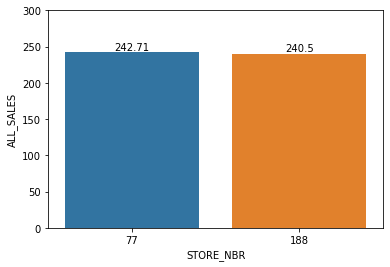

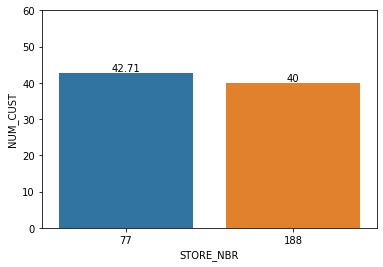

In [58]:
# Visualize the trail stroe and control before trail period
store77 = store_metrics[(store_metrics['STORE_NBR'] == '77') |\
                        (store_metrics['STORE_NBR'] == f'{store_metrics.iloc[control_store[0],0]}')]

# For total dollars of sales
store77_bar = sns.barplot(data=store77, x='STORE_NBR', y='ALL_SALES')
plt.ylim(ymax= 300)
store77_bar.bar_label(store77_bar.containers[0])
plt.show()

#For monthly number of customers
store77_bar = sns.barplot(data=store77, x='STORE_NBR', y='NUM_CUST')
plt.ylim(ymax= 60)
store77_bar.bar_label(store77_bar.containers[0])
plt.show()

### Store 86

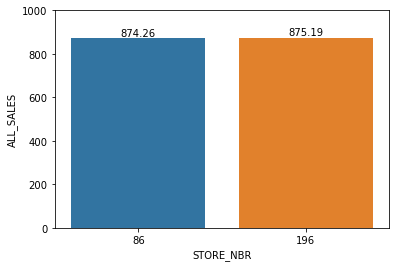

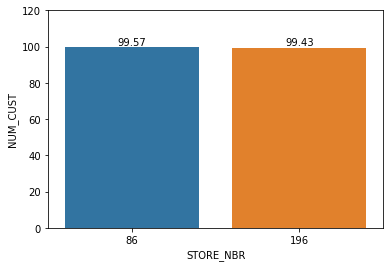

In [60]:
# Visualize the trail stroe and control before trail period
store86 = store_metrics[(store_metrics['STORE_NBR'] == '86') |\
                        (store_metrics['STORE_NBR'] == f'{store_metrics.iloc[control_store[1],0]}')]

# For total dollars of sales
store86_bar = sns.barplot(data=store86, x='STORE_NBR', y='ALL_SALES')
plt.ylim(ymax= 1000)
store86_bar.bar_label(store86_bar.containers[0])
plt.show()

#For monthly number of customers
store86_bar = sns.barplot(data=store86, x='STORE_NBR', y='NUM_CUST')
plt.ylim(ymax= 120)
store86_bar.bar_label(store86_bar.containers[0])
plt.show()

### Store 88

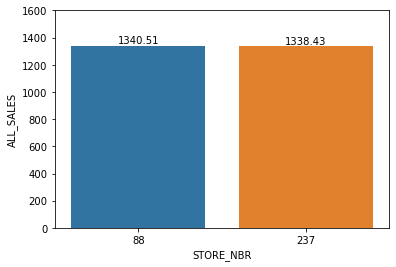

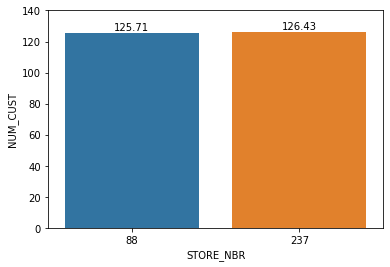

In [64]:
# Visualize the trail stroe and control before trail period
store88 = store_metrics[(store_metrics['STORE_NBR'] == '88') |\
                        (store_metrics['STORE_NBR'] == f'{store_metrics.iloc[control_store[2],0]}')]

# For total dollars of sales
store86_bar = sns.barplot(data=store88, x='STORE_NBR', y='ALL_SALES')
plt.ylim(ymax= 1600)
store86_bar.bar_label(store86_bar.containers[0])
plt.show()

#For monthly number of customers
store86_bar = sns.barplot(data=store88, x='STORE_NBR', y='NUM_CUST')
plt.ylim(ymax= 140)
store86_bar.bar_label(store86_bar.containers[0])
plt.show()